# CNN Univariate

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import keras
from keras.activations import sigmoid
from keras.models import Sequential
from keras import models, layers, backend, optimizers
from keras.layers import Dropout, BatchNormalization, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
import time
from math import sqrt

In [4]:
# read the dataframe and assign the time column as the index values of the dataframe
file = "./dataset.csv"
df = pd.read_csv(file, index_col='Date', parse_dates=True)
df

,AUD,EUR,NZD,GBP,BRL,CAD,CNY,DKK,HKD,INR,...,CHF,TWD,THB,VEB,gdpGBP,gdpUSD,GBR_Value,USA_Value,liborUSD,liborGBP
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-01,0.631500,0.973100,0.490400,1.615000,1.795000,1.446800,8.277400,7.644500,7.780700,43.620000,...,1.654000,31.750000,37.510000,6.563000e-01,100.90500,101.5818,NaN,NaN,5.84138,5.97114
2000-03-01,0.606700,0.970000,0.485300,1.584900,1.769000,1.447000,8.278600,7.673000,7.782400,43.630000,...,1.656800,30.750000,38.110000,6.630000e-01,100.93520,101.6581,NaN,NaN,5.96000,5.88913
2000-05-01,0.580000,0.912000,0.483500,1.555800,1.807000,1.478300,8.279900,8.169500,7.789000,43.670000,...,1.713500,30.650000,38.120000,6.758000e-01,100.91940,101.7747,NaN,NaN,6.43857,5.99906
2000-06-01,0.572100,0.930700,0.456100,1.491500,1.821000,1.491000,8.277100,8.022500,7.792000,44.650000,...,1.687800,30.900000,39.190000,6.818000e-01,100.88750,101.7674,NaN,NaN,6.66582,5.99415
2000-08-01,0.580500,0.922800,0.454600,1.499200,1.786000,1.489200,8.278800,8.084000,7.799300,45.150000,...,1.675800,31.150000,41.090000,6.880000e-01,100.81010,101.6210,NaN,NaN,6.57688,5.94362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-01,1.522934,0.920376,1.630278,0.785825,4.919647,1.338190,7.156337,6.860283,7.819398,82.963015,...,0.857789,31.293190,35.328375,3.615638e+06,99.75476,100.4912,-2.506553,-2.901892,5.43596,5.32646
2024-03-01,1.531798,0.923196,1.638305,0.790470,4.948222,1.355491,7.195813,6.881556,7.829028,82.858687,...,0.884360,31.599983,35.869689,3.607648e+06,99.75476,100.4912,-2.506553,-2.901892,5.43989,5.31892
2024-04-01,1.542390,0.931698,1.682959,0.797231,5.066569,1.358095,7.230758,6.949495,7.826226,83.534071,...,0.905549,32.078999,36.605359,3.622553e+06,99.75476,100.4912,-2.506553,-2.901892,5.43280,-


In [5]:
def CreateLaggedSequence(data, lag):
    # make two lists for PredictorSequences and ResponseVariables
    PredictorSequences, ResponseVariables = list(), list()
    for i in range(len(data)):
        # mark the range of the sequence
        end_i = i + lag
        # check when the data ends
        if end_i+1 > len(data):
            # stop sequence creation
            break
        # get the predictors and responses
        PredictorSequence = data[i:end_i]
        ResponseVariable = data[end_i]
        # append them to the lists
        PredictorSequences.append(PredictorSequence)
        ResponseVariables.append(ResponseVariable)
        # print(end_i)
    return np.array(PredictorSequences), np.array(ResponseVariables)

In [6]:
# Get the univariate series
X = df['GBP']
np_X = np.array(X)
# Create the lagged values for the series (50 lags)
X, y = CreateLaggedSequence(np_X, 50) #25
lag = X.shape[1]
NumberOfFeatures = 1 # for univariate input
# reshape it for the process
X = X.reshape(X.shape[0], X.shape[1], NumberOfFeatures) # a reshape is needed for the CNN architecture
X.shape, y.shape, len(X), len(y)

((153, 50, 1), (153,), 153, 153)

In [7]:
# split the train and test sets (last 50 observation spared for the test)
x_train, x_test = X[:-50], X[-50:]
y_train, y_test = y[:-50], y[-50:]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((103, 50, 1), (50, 50, 1), (103,), (50,))

In [8]:
# define new activation function
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [9]:
# create a start point for timer
start = time.time()

# design the model
backend.clear_session()
model = Sequential()

model.add(Conv1D(filters=233, kernel_size=3, padding='same', activation=tf.keras.backend.sin, input_shape=(lag, NumberOfFeatures)))
model.add(Conv1D(filters=233, kernel_size=3, padding='same', activation=tf.keras.backend.sin))

model.add(Flatten())

model.add(layers.Dense(3*2**8, activation=tf.keras.backend.sin, kernel_initializer='he_uniform'))
model.add(Dropout(0.5))

model.add(layers.Dense(1, activation='swish'))

# compile the model
model.compile(optimizer = optimizers.Adam(learning_rate=0.000007), loss = 'mse', metrics = ['mae'])
#get the summary of the model
model.summary()

################################################################################

# fit the model
history = model.fit(x_train, y_train, 
            epochs = 2**10, 
            batch_size = 3615, 
            validation_split = 0.20,
            verbose = 1, 
            callbacks=[EarlyStopping(monitor='val_mae', patience=2**6, restore_best_weights = True)]) # restore the best values

#evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('test_acc:', test_acc)

# end the timer and print the total time passed
end = time.time()
print("Total time:", end-start, "seconds")

/Users/tranphuctho276/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 50, 233)        │           932 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 233)        │       163,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11650)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 768)            │     8,947,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,112,769 (34.76 MB)

 Trainable params: 9,112,769 (34.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - loss: 2.7717 - mae: 1.6446 - val_loss: 1.4044 - val_mae: 1.1840
Epoch 2/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.2123 - mae: 1.4679 - val_loss: 0.9786 - val_mae: 0.9881
Epoch 3/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.6455 - mae: 1.2515 - val_loss: 0.5730 - val_mae: 0.7555
Epoch 4/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.0124 - mae: 0.9421 - val_loss: 0.2461 - val_mae: 0.4939
Epoch 5/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.4939 - mae: 0.6264 - val_loss: 0.0488 - val_mae: 0.2157
Epoch 6/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.2475 - mae: 0.4137 - val_loss: 0.0064 - val_mae: 0.0685
Epoch 7/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1444 - mae: 0.2958 - val_loss: 0.1034 - val_mae: 0.3177
Epoch 8/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2884 - mae: 0.4387 - val_loss: 0.2580 - val_mae: 0.5053
Epoch 9/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.3

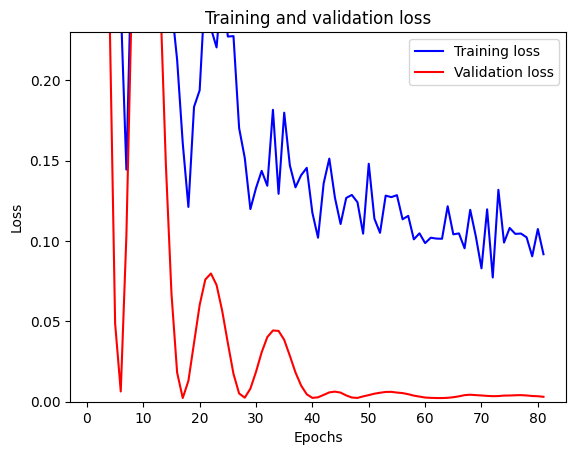

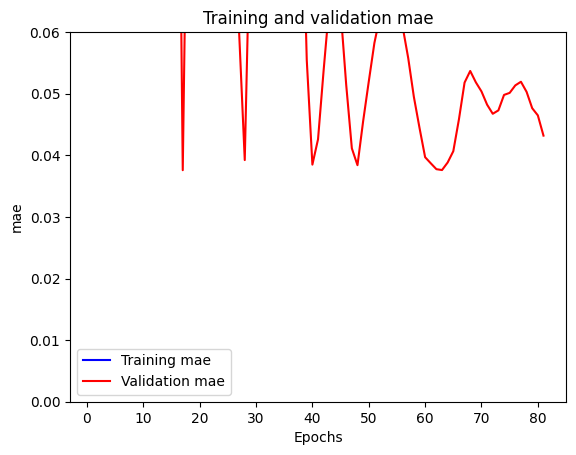

In [10]:
# get the history of the fitting process
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
mae_values = history_dict['mae']
val_mae_values = history_dict['val_mae']
epochs = range(1, len(history_dict['mae']) + 1)
# plot the training and validation losses
plt.plot(epochs, loss_values, label = 'Training loss', color='blue')
plt.plot(epochs, val_loss_values, label = 'Validation loss', color='red')
plt.ylim(0,0.23)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# plot the training and validation mae (mean absolute error)
plt.plot(epochs, mae_values, label = 'Training mae', color='blue')
plt.plot(epochs, val_mae_values, label = 'Validation mae', color='red')
plt.ylim(0,0.06)
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

In [11]:
# predict the model on the test set
yhat = model.predict(x_test, verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [12]:
# convert the predictions series
predictions = pd.Series(yhat.reshape((50)), index=df['GBP'].index[-50:])
# extract the actual values
actuals = df['GBP'][-50:]

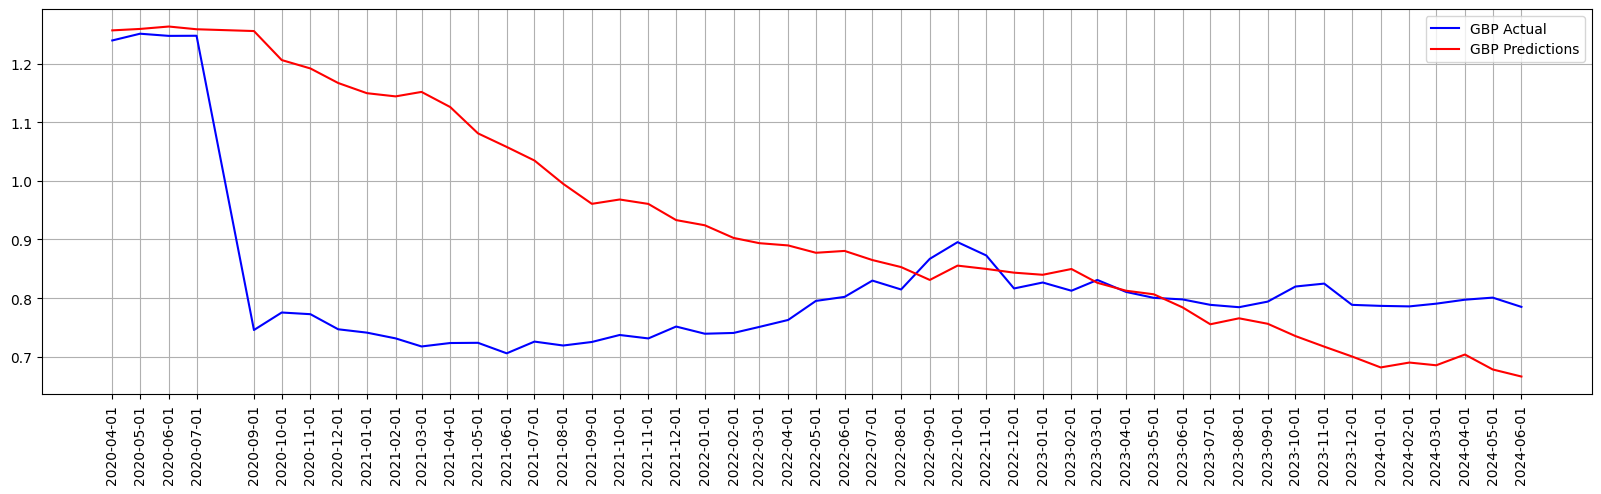

Test RMSE: 0.21541


In [13]:
# evaluate forecasts and plot them together
plt.figure(figsize=(20,5))
plt.plot(actuals.index, actuals, color='blue')
plt.plot(actuals.index, predictions, color='red')
plt.legend(('GBP Actual', 'GBP Predictions'))
plt.xticks(actuals.index, rotation=90)
plt.grid(True)
plt.show()

rmse = sqrt(mean_squared_error(actuals, predictions))
print('Test RMSE: %.5f' % rmse)